In [10]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 24.7 ms (started: 2021-08-23 11:16:17 +08:00)


In [54]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 #2  Aug 23, 2021'

#git push origin master
git push

origin	git@github.com:ustchope/keras_developer_guides-.git (fetch)
origin	git@github.com:ustchope/keras_developer_guides-.git (push)
[main b364734] 更新 #2  Aug 23, 2021
 1 file changed, 1979 insertions(+), 100 deletions(-)


To git@github.com:ustchope/keras_developer_guides-.git
   3aea551..b364734  main -> main


time: 4.84 s (started: 2021-08-23 12:29:47 +08:00)


In [3]:
#设置使用的gpu
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 3.52 s (started: 2021-08-23 10:29:52 +08:00)


# 设置

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

time: 832 µs (started: 2021-08-23 11:16:24 +08:00)


# 简介

本指南涵盖使用内置 API 进行训练和验证（例如 `Model.fit()`、`Model.evaluate()` 和 `Model.predict()`）时的训练、评估和预测（推理）模型。

如果您对在指定自己的训练步骤函数时利用 `fit()` 感兴趣，请参阅自定义 `fit()` 指南。

如果您有兴趣从头开始编写自己的训练和评估循环，请参阅“从头开始编写训练循环”指南。

一般来说，无论您是使用内置循环还是编写自己的循环，模型训练和评估在每种 Keras 模型中都严格按照相同的方式进行——顺序模型、使用功能 API 构建的模型以及通过以下方式从头开始编写的模型 模型子类化。

本指南不包括分布式训练，这在我们的多 GPU 和分布式训练指南中有所介绍。

# API 概述：第一个端到端示例

将数据传递给模型的内置训练循环时，您应该使用 NumPy 数组（如果您的数据很小并且适合内存）或 tf.data 数据集对象。 在接下来的几段中，我们将使用 MNIST 数据集作为 NumPy 数组，以演示如何使用优化器、损失和指标。

让我们考虑以下模型（在这里，我们使用 Functional API 构建，但它也可以是 Sequential 模型或子类模型）：

In [6]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 37.5 ms (started: 2021-08-23 10:29:59 +08:00)


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
time: 4.22 ms (started: 2021-08-21 15:11:08 +08:00)


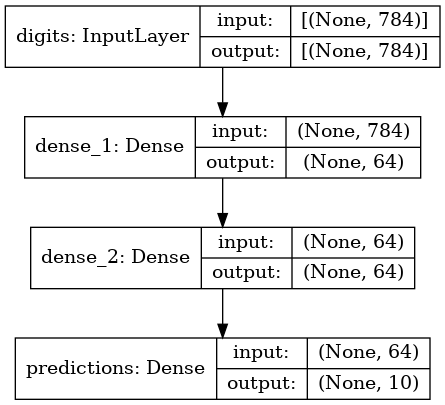

time: 6.93 s (started: 2021-08-21 15:13:47 +08:00)


In [10]:
plot_model(model, show_shapes=True)

以下是典型的端到端工作流程，包括：
* 训练
* 对从原始训练数据生成的保留集进行验证
* 对测试数据的评估

我们将在此示例中使用 MNIST 数据。

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

time: 437 ms (started: 2021-08-23 10:30:09 +08:00)


我们指定训练配置（优化器、损失、指标）：

In [8]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

time: 22.8 ms (started: 2021-08-23 10:30:11 +08:00)


我们调用 fit()，它将通过将数据切成大小为 batch_size 的“批次”来训练模型，并在给定数量的 epoch 中重复迭代整个数据集。

In [9]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/20
782/782 [==============================] - 9s 9ms/step - loss: 0.3432 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.2568 - val_sparse_categorical_accuracy: 0.9224
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1450 - val_sparse_categorical_accuracy: 0.9567
Epoch 3/20
782/782 [==============================] - 7s 10ms/step - loss: 0.1187 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.1075 - val_sparse_categorical_accuracy: 0.9685
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.1069 - val_sparse_categorical_accuracy: 0.9705
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.1024 - val_sparse_categorical_accuracy: 0.9721
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss

返回的历史对象保存了训练期间损失值和度量值的记录：

In [11]:
history.history

{'loss': [0.06649843603372574,
  0.05826172977685928,
  0.05100547522306442,
  0.04415423795580864,
  0.03883035108447075,
  0.03441018983721733,
  0.029938992112874985,
  0.02597038261592388,
  0.02442266047000885,
  0.02133406326174736,
  0.018334824591875076,
  0.01701589673757553,
  0.015719568356871605,
  0.012882999144494534,
  0.012036602944135666,
  0.010108149610459805,
  0.009029699489474297,
  0.007908957079052925,
  0.008356831967830658,
  0.006960942409932613],
 'sparse_categorical_accuracy': [0.9801599979400635,
  0.98225998878479,
  0.9843400120735168,
  0.9873200058937073,
  0.9884399771690369,
  0.9891999959945679,
  0.9907199740409851,
  0.9918400049209595,
  0.992579996585846,
  0.993179976940155,
  0.994159996509552,
  0.9944999814033508,
  0.9945600032806396,
  0.9963200092315674,
  0.9960399866104126,
  0.9965000152587891,
  0.9969199895858765,
  0.9975200295448303,
  0.997160017490387,
  0.9976599812507629],
 'val_loss': [0.10455715656280518,
  0.1017419770359993

time: 9.83 ms (started: 2021-08-21 15:25:36 +08:00)


In [7]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

time: 1.16 ms (started: 2021-08-21 15:48:11 +08:00)


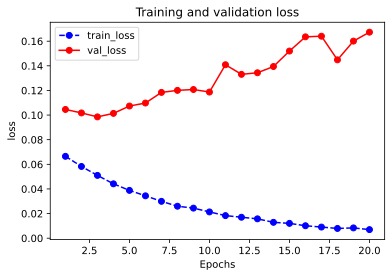

time: 250 ms (started: 2021-08-21 15:25:43 +08:00)


In [13]:
plot_metric(history,"loss")

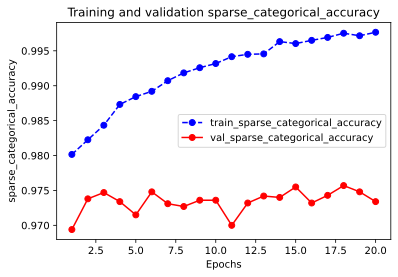

time: 236 ms (started: 2021-08-21 15:26:09 +08:00)


In [14]:
plot_metric(history,"sparse_categorical_accuracy")

我们通过`evaluate()`在测试数据上评估模型：

In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 1s 7ms/step - loss: 0.1608 - sparse_categorical_accuracy: 0.9730
test loss, test acc: [0.1607811003923416, 0.9729999899864197]
time: 679 ms (started: 2021-08-21 15:27:56 +08:00)


In [17]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
predictions shape: (3, 10)
time: 65.9 ms (started: 2021-08-21 15:27:59 +08:00)


现在，让我们详细回顾一下这个工作流程的每一部分。

# compile() 方法：指定损失、指标和优化器

要使用 fit() 训练模型，您需要指定损失函数、优化器以及可选的一些要监控的指标。

您将这些作为 compile() 方法的参数传递给模型：

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

指标参数应该是一个列表——你的模型可以有任意数量的指标。

如果您的模型有多个输出，您可以为每个输出指定不同的损失和度量，并且您可以调整每个输出对模型总损失的贡献。 您将在将数据传递到多输入、多输出模型部分中找到有关此的更多详细信息。

请注意，如果您对默认设置感到满意，在许多情况下，可以通过字符串标识符作为快捷方式指定优化器、损失和指标：

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

为了以后重用，让我们把我们的模型定义和编译步骤放在函数中； 我们将在本指南中的不同示例中多次调用它们。

In [12]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

time: 1.81 ms (started: 2021-08-23 11:16:32 +08:00)


## 许多内置优化器、损失和指标可用

一般来说，您不必从头开始创建自己的损失、指标或优化器，因为您需要的可能已经是 Keras API 的一部分：

优化器：
* SGD()（有或没有动量）
* RMSprop()
* Adam()
等。

损失：
* MeanSquaredError()
* KLDivergence()
* CosineSimilarity()
* etc.

度量：
* AUC()
* Precision()
* Recall()
* etc.

## 自定义损失

如果您需要创建自定义损失，Keras 提供了两种方法。

第一种方法涉及创建一个接受输入 y_true 和 y_pred 的函数。 以下示例显示了一个计算真实数据和预测之间的均方误差的损失函数：

In [13]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 7s 9ms/step - loss: 0.0158


time: 7.23 s (started: 2021-08-23 11:16:36 +08:00)


如果您需要一个接受 `y_true` 和 `y_pred` 旁边参数的损失函数，您可以子类化 `tf.keras.losses.Loss` 类并实现以下两个方法：
* `__init__(self)`：接受在调用损失函数期间传递的参数
* `call(self, y_true, y_pred)`: 使用目标 (`y_true`) 和模型预测 (`y_pred`) 来计算模型的损失

假设您想使用均方误差，但增加了一项将使预测值远离 0.5（我们假设分类目标是单热编码并采用 0 和 1 之间的值）。 这会激励模型不要过于自信，这可能有助于减少过度拟合（我们不知道它是否有效，直到我们尝试！）。

以下是您的操作方法：

In [14]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 7s 9ms/step - loss: 0.0386


time: 7.19 s (started: 2021-08-23 11:16:51 +08:00)


## 自定义指标

如果您需要一个不属于 API 的指标，您可以通过继承 `tf.keras.metrics.Metric` 类轻松创建自定义指标。 您将需要实现 4 种方法：
* `__init__(self)`，您将在其中为您的指标创建状态变量。
* `update_state(self, y_true, y_pred, sample_weight=None)`，它使用目标 `y_true` 和模型预测 `y_pred` 来更新状态变量。
* `result(self)`，它使用状态变量来计算最终结果。
* `reset_states(self)`，它重新初始化指标的状态。

状态更新和结果计算是分开的（分别在 update_state() 和 result() 中），因为在某些情况下，结果计算可能非常昂贵并且只能定期进行。

这是一个简单的示例，展示了如何实现 CategoricalTruePositives 指标，该指标计算有多少样本被正确分类为属于给定类：

In [15]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 8s 10ms/step - loss: 0.3462 - categorical_true_positives: 45150.0000
Epoch 2/3
 18/782 [..............................] - ETA: 7s - loss: 0.1860 - categorical_true_positives: 1088.0000

/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:254: UserWarning: Metric CategoricalTruePositives implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


782/782 [==============================] - 7s 9ms/step - loss: 0.1648 - categorical_true_positives: 47602.0000
Epoch 3/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1181 - categorical_true_positives: 48189.0000


time: 22.6 s (started: 2021-08-23 11:17:34 +08:00)


## 处理不符合标准签名的损失和指标

绝大多数损失和指标可以从 y_true 和 y_pred 计算，其中 y_pred 是模型的输出——但不是全部。 例如，正则化损失可能只需要激活一个层（在这种情况下没有目标），而这个激活可能不是模型输出。

在这种情况下，您可以从自定义层的调用方法内部调用 self.add_loss(loss_value)。 以这种方式添加的损失会在训练期间添加到“主要”损失中（传递给 compile() 的损失）。 这是一个添加活动正则化的简单示例（注意活动正则化内置在所有 Keras 层中——这一层只是为了提供一个具体的例子）：

In [16]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 7s 8ms/step - loss: 2.5474


time: 6.87 s (started: 2021-08-23 11:22:15 +08:00)


您可以使用 add_metric() 对记录指标值执行相同的操作：

In [17]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 7s 8ms/step - loss: 0.3556 - std_of_activation: 0.9600


time: 6.91 s (started: 2021-08-23 11:23:08 +08:00)


在 Functional API 中，您还可以调用 `model.add_loss(loss_tensor)` 或 `model.add_metric(metric_tensor, name,aggregation)`。

这是一个简单的例子：

In [18]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 7s 8ms/step - loss: 2.5093 - std_of_activation: 0.0019


time: 7.01 s (started: 2021-08-23 11:24:14 +08:00)


请注意，当您通过 add_loss() 传递损失时，可以在没有损失函数的情况下调用 compile()，因为模型已经有一个损失可以最小化。

考虑以下 LogisticEndpoint 层：它将目标和 logits 作为输入，并通过 add_loss() 跟踪交叉熵损失。 它还通过 add_metric() 跟踪分类准确性。

In [19]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

time: 1.96 ms (started: 2021-08-23 11:26:02 +08:00)


您可以在具有两个输入（输入数据和目标）的模型中使用它，编译时没有损失参数，如下所示：

In [20]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 273ms/step - loss: 0.9510 - binary_accuracy: 0.0000e+00


time: 477 ms (started: 2021-08-23 11:27:19 +08:00)


有关训练多输入模型的更多信息，请参阅将数据传递到多输入、多输出模型部分。

## 自动设置验证坚持集

在您看到的第一个端到端示例中，我们使用了 validation_data 参数将 NumPy 数组 (x_val, y_val) 的元组传递给模型，以在每个 epoch 结束时评估验证损失和验证指标。

这是另一种选择：参数validation_split 允许您自动保留部分训练数据以进行验证。 参数值表示保留用于验证的数据的比例，因此应将其设置为大于 0 且小于 1 的数字。例如，validation_split=0.2 表示“使用 20% 的数据进行验证”，并且 validation_split=0.6 表示“使用 60% 的数据进行验证”。

计算验证的方法是在任何改组之前获取 fit() 调用接收到的数组的最后 x% 样本。

请注意，您只能在使用 NumPy 数据进行训练时使用 validation_split。

In [21]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 5s 8ms/step - loss: 0.3774 - sparse_categorical_accuracy: 0.8942 - val_loss: 0.2306 - val_sparse_categorical_accuracy: 0.9323


time: 5.27 s (started: 2021-08-23 11:30:25 +08:00)


# 来自 tf.data 数据集的训练和评估

在过去的几段中，您已经看到了如何处理损失、指标和优化器，并且您已经看到了当您的数据作为 NumPy 数组传递时如何在 fit() 中使用 validation_data 和 validation_split 参数。

现在让我们看一下您的数据以 tf.data.Dataset 对象的形式出现的情况。

tf.data API 是 TensorFlow 2.0 中的一组实用程序，用于以快速且可扩展的方式加载和预处理数据。

有关创建数据集的完整指南，请参阅 tf.data 文档。

您可以将 Dataset 实例直接传递给 fit()、evaluate() 和 predict() 方法：

In [22]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 7s 9ms/step - loss: 0.3312 - sparse_categorical_accuracy: 0.9061
Epoch 2/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1581 - sparse_categorical_accuracy: 0.9535
Epoch 3/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9657
Evaluate
157/157 [==============================] - 1s 7ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.9669


{'loss': 0.108725406229496, 'sparse_categorical_accuracy': 0.9668999910354614}

time: 23 s (started: 2021-08-23 11:31:57 +08:00)


请注意，数据集在每个 epoch 结束时重置，因此可以在下一个 epoch 中重复使用。

如果您只想在此数据集中的特定数量的批次上运行训练，您可以传递 steps_per_epoch 参数，该参数指定模型在进入下一个时期之前应使用此数据集运行的训练步骤数。

如果你这样做，数据集不会在每个 epoch 结束时重置，而是我们只是继续绘制下一批。 数据集最终会耗尽数据（除非它是一个无限循环的数据集）。

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 1s 9ms/step - loss: 0.8065 - sparse_categorical_accuracy: 0.7891
Epoch 2/3
100/100 [==============================] - 1s 9ms/step - loss: 0.3771 - sparse_categorical_accuracy: 0.8906
Epoch 3/3
100/100 [==============================] - 1s 9ms/step - loss: 0.3272 - sparse_categorical_accuracy: 0.9055


time: 3.32 s (started: 2021-08-23 11:33:07 +08:00)


## 使用验证数据集

您可以在 fit() 中将 Dataset 实例作为 validation_data 参数传递：

In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 8s 10ms/step - loss: 0.3353 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.1787 - val_sparse_categorical_accuracy: 0.9491


time: 8.67 s (started: 2021-08-23 11:33:55 +08:00)


在每个时期结束时，模型将迭代验证数据集并计算验证损失和验证指标。

如果您只想在此数据集中的特定数量的批次上运行验证，则可以传递 validation_steps 参数，该参数指定模型在中断验证并进入下一个时期之前应使用验证数据集运行多少验证步骤：

In [25]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 7s 9ms/step - loss: 0.3352 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.3727 - val_sparse_categorical_accuracy: 0.9047


time: 7.77 s (started: 2021-08-23 11:34:29 +08:00)


请注意，验证数据集将在每次使用后重置（因此您将始终在不同时期对相同样本进行评估）。

从 Dataset 对象进行训练时，不支持参数 validation_split（从训练数据生成保持集），因为此功能需要能够对数据集的样本进行索引，而 Dataset API 通常无法做到这一点。

# 支持的其他输入格式

除了 NumPy 数组、热切张量和 TensorFlow 数据集，还可以使用 Pandas 数据帧或从生成批量数据和标签的 Python 生成器来训练 Keras 模型。

特别是， keras.utils.Sequence 类提供了一个简单的接口来构建 Python 数据生成器，这些生成器具有多处理感知能力并且可以进行混洗。

一般来说，我们建议您使用：
* NumPy 输入数据，如果您的数据很小并且适合内存
* `Dataset` 对象，如果您有大型数据集并且需要进行分布式训练
* 如果您拥有大型数据集并且需要进行大量在 TensorFlow 中无法完成的自定义 Python 端处理（例如，如果您依赖外部库进行数据加载或预处理），请使用`Sequence`对象。

# 使用 keras.utils.Sequence 对象作为输入

keras.utils.Sequence 是一个实用程序，您可以将其子类化以获得具有两个重要属性的 Python 生成器：
* 它适用于多进程。
* 它可以被洗牌（例如，当在 fit() 中传递 shuffle=True 时）。

一个 Sequence 必须实现两个方法：
* `__getitem__`
* `__len__`

`__getitem__` 方法应该返回一个完整的批次。 如果你想在 epoch 之间修改你的数据集，你可以实现 on_epoch_end。

这是一个快速示例：

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)

# 使用样本加权和类加权

在默认设置下，样本的权重由其在数据集中的频率决定。 有两种方法可以对数据进行加权，与采样频率无关：
* 类别权重
* 样本权重

## 类别权重

这是通过将字典传递给 Model.fit() 的 class_weight 参数来设置的。 该字典将类索引映射到应用于属于此类的样本的权重。

这可用于在不重新采样的情况下平衡类，或训练一个对特定类赋予更多重要性的模型。

例如，如果类“0”是数据中表示为类“1”的一半，则可以使用 Model.fit(..., class_weight={0: 1., 1: 0.5})。

这是一个 NumPy 示例，我们使用类权重或样本权重来更加重视类 #5（即 MNIST 数据集中的数字“5”）的正确分类。

In [30]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
782/782 [==============================] - 7s 9ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.9025


time: 7.51 s (started: 2021-08-23 11:46:20 +08:00)


## 样本权重

对于细粒度控制，或者如果您不构建分类器，则可以使用“样本权重”。
* 从 NumPy 数据训练时：将 sample_weight 参数传递给 Model.fit()。
* 当从 tf.data 或任何其他类型的迭代器训练时：Yield (input_batch, label_batch, sample_weight_batch) 元组。
“样本权重”数组是一个数字数组，用于指定批次中每个样本在计算总损失时应具有的权重。 它通常用于不平衡的分类问题（这个想法是给很少见的类更多的权重）。

当使用的权重为 1 和 0 时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

In [31]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 7s 8ms/step - loss: 0.3828 - sparse_categorical_accuracy: 0.8994


time: 11.3 s (started: 2021-08-23 11:48:36 +08:00)


这是一个相应的`Dataset`示例：

In [34]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 8s 9ms/step - loss: 0.3696 - sparse_categorical_accuracy: 0.9035


time: 8 s (started: 2021-08-23 11:50:46 +08:00)


# 将数据传递给多输入、多输出模型

在前面的示例中，我们正在考虑具有单个输入（形状为 (764,) 的张量）和单个输出（形状为 (10,) 的预测张量）的模型。 但是具有多个输入或输出的模型呢？

考虑以下模型，它具有形状为 (32, 32, 3)（即（高度、宽度、通道））的图像输入和形状为 (None, 10) 的时间序列输入（即（时间步长、特征））。 我们的模型将根据这些输入的组合计算出两个输出：“分数”（形状 (1,)）和五个类别的概率分布（形状 (5,)）。

In [35]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

time: 82 ms (started: 2021-08-23 11:52:21 +08:00)


让我们绘制这个模型，这样你就可以清楚地看到我们在这里做什么（注意图中显示的形状是批次形状，而不是每个样本的形状）。

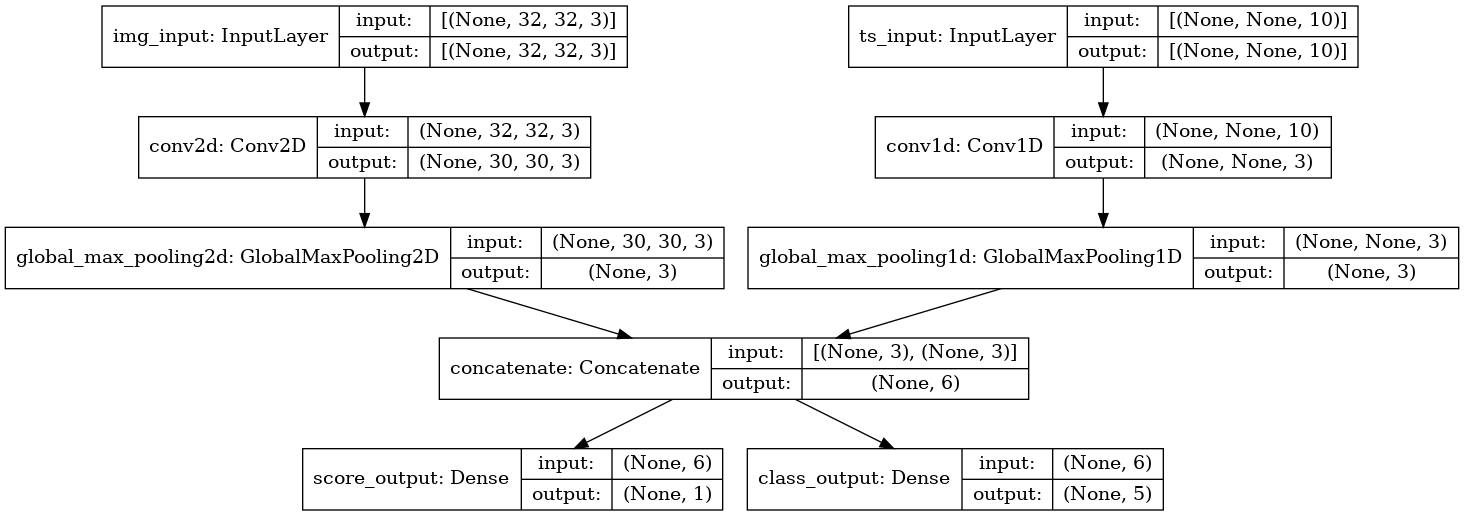

time: 419 ms (started: 2021-08-23 11:53:06 +08:00)


In [36]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

在编译时，我们可以通过将损失函数作为列表传递来为不同的输出指定不同的损失：

In [37]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

time: 24.2 ms (started: 2021-08-23 11:54:05 +08:00)


如果我们只向模型传递一个损失函数，那么每个输出都会应用相同的损失函数（这在这里不合适）。

同样对于指标：

In [38]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

time: 23 ms (started: 2021-08-23 11:54:38 +08:00)


由于我们为输出层命名，我们还可以通过字典指定每个输出的损失和指标：

In [39]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

time: 21.7 ms (started: 2021-08-23 11:55:20 +08:00)


如果您有 2 个以上的输出，我们建议使用显式名称和字典。

可以使用 loss_weights 参数为不同的特定于输出的损失赋予不同的权重（例如，在我们的示例中，人们可能希望通过将类损失的重要性提高 2 倍来优先考虑“得分”损失）：

In [40]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

time: 25.7 ms (started: 2021-08-23 11:55:46 +08:00)


您也可以选择不计算某些输出的损失，如果这些输出用于预测而不是用于训练：

In [41]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

time: 20.9 ms (started: 2021-08-23 11:56:17 +08:00)


在 fit() 中将数据传递到多输入或多输出模型的工作方式与在 compile 中指定损失函数的方式类似：您可以传递 NumPy 数组列表（以 1:1 映射到接收损失函数的输出） ) 或 dicts 将输出名称映射到 NumPy 数组。

In [42]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 1s 12ms/step - loss: 13.7768 - score_output_loss: 1.3199 - class_output_loss: 12.4569


time: 9.93 s (started: 2021-08-23 11:57:29 +08:00)


这是 Dataset 用例：与我们对 NumPy 数组所做的类似，Dataset 应该返回一个 dicts 元组。

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 500ms/step - loss: 13.4791 - score_output_loss: 1.1759 - class_output_loss: 12.3032


time: 1.48 s (started: 2021-08-23 11:59:32 +08:00)


# 使用回调

Keras 中的回调是在训练期间的不同时间点（在一个周期开始时、在一个批次结束时、在一个周期结束时等）被调用的对象。 它们可用于实现某些行为，例如：
* 在训练期间的不同点进行验证（除了内置的 per-epoch 验证）
* 定期检查模型或当模型超过某个准确度阈值时
* 当训练似乎趋于平稳时改变模型的学习率
* 当训练似乎趋于平稳时对顶层进行微调
* 在训练结束或超过特定性能阈值时发送电子邮件或即时消息通知


回调可以作为列表传递给您对 fit() 的调用：

In [47]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 5s 7ms/step - loss: 0.3643 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.2139 - val_sparse_categorical_accuracy: 0.9363
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 0.1700 - sparse_categorical_accuracy: 0.9492 - val_loss: 0.1794 - val_sparse_categorical_accuracy: 0.9469
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.9627 - val_loss: 0.1566 - val_sparse_categorical_accuracy: 0.9553
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.1012 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.1379 - val_sparse_categorical_accuracy: 0.9597
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 0.0848 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.1518 - val_sparse_categorical_accuracy: 0.9567
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 0.0719 - sparse_categorica

time: 27 s (started: 2021-08-23 12:01:52 +08:00)


## 许多内置回调可用

Keras 中已经有许多内置回调可用，例如：
* ModelCheckpoint：定期保存模型。
* EarlyStopping：当训练不再改善验证指标时停止训练。
* TensorBoard：定期编写可以在 TensorBoard 中可视化的模型日志（更多细节在“可视化”部分）。
* CSVLogger：将损失和指标数据流式传输到 CSV 文件。
* 等等。

有关完整列表，请参阅回调文档。

## 编写自己的回调

您可以通过扩展基类 keras.callbacks.Callback 来创建自定义回调。 回调可以通过类属性 self.model 访问其关联的模型。

请务必阅读编写自定义回调的完整指南。

这是一个在训练期间保存每批损失值列表的简单示例：

In [49]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

time: 1.25 ms (started: 2021-08-23 12:05:22 +08:00)


# Checkpointing模型

当您在相对较大的数据集上训练模型时，以频繁的时间间隔保存模型的检查点至关重要。

实现这一点的最简单方法是使用 ModelCheckpoint 回调：

In [50]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # 保存模型的路径
        # 下面两个参数的意思是我们会覆盖当前检查点当且仅当`val_loss` 得分有所提高。
        # 保存的模型名称将包括当前epoch。
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
625/625 [==============================] - 5s 7ms/step - loss: 0.3891 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.9250

Epoch 00001: val_loss improved from inf to 0.24354, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1/assets
Epoch 2/2
625/625 [==============================] - 4s 7ms/step - loss: 0.1878 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.1955 - val_sparse_categorical_accuracy: 0.9415

Epoch 00002: val_loss improved from 0.24354 to 0.19554, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2/assets


time: 11.6 s (started: 2021-08-23 12:09:59 +08:00)


ModelCheckpoint 回调可用于实现容错：在训练随机中断的情况下，能够从模型的最后保存状态重新开始训练。 这是一个基本示例：

In [51]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model
1563/1563 [==============================] - 20s 13ms/step - loss: 0.2967 - sparse_categorical_accuracy: 0.9129


time: 20.4 s (started: 2021-08-23 12:17:28 +08:00)


您还可以编写自己的回调来保存和恢复模型。

有关序列化和保存的完整指南，请参阅保存和序列化模型指南。

# 使用学习率计划

训练深度学习模型时的常见模式是随着训练的进行逐渐减少学习。 这通常被称为“学习率衰减”。

学习衰减计划可以是静态的（预先固定，作为当前时期或当前批次索引的函数）或动态的（响应模型的当前行为，特别是验证损失）。

## 将调度传递给优化器

您可以通过在优化器中将调度对象作为 learning_rate 参数传递来轻松使用静态学习率衰减调度：

In [52]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

time: 1.67 ms (started: 2021-08-23 12:24:00 +08:00)


有几个内置计划可用：ExponentialDecay、PiecewiseConstantDecay、PolynomialDecay 和 InverseTimeDecay。

## 使用回调实现动态学习率计划

使用这些调度对象无法实现动态学习率调度（例如，在验证损失不再改善时降低学习率），因为优化器无法访问验证指标。

但是，回调确实可以访问所有指标，包括验证指标！ 因此，您可以通过使用回调来修改优化器上的当前学习率来实现此模式。 事实上，这甚至是作为 ReduceLROnPlateau 回调内置的。

# 在训练期间可视化损失和指标

在训练期间密切关注模型的最佳方法是使用 TensorBoard——一个基于浏览器的应用程序，您可以在本地运行，它为您提供：
* 用于训练和评估的损失和指标的实时图
*（可选）层激活直方图的可视化
*（可选）嵌入层学习的嵌入空间的 3D 可视化

如果您已经使用 pip 安装了 TensorFlow，您应该能够从命令行启动 TensorBoard：

In [ ]:
tensorboard --logdir=/full_path_to_your_logs

## 使用 TensorBoard 回调

将 TensorBoard 与 Keras 模型和 fit() 方法一起使用的最简单方法是 TensorBoard 回调。

在最简单的情况下，只需指定您希望回调写入日志的位置，就可以了：

In [53]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

time: 316 ms (started: 2021-08-23 12:28:44 +08:00)
